## Emily's state transition function

In [241]:
import Pkg
Pkg.add("Plots")
using Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [242]:
include("state.jl")

TR (generic function with 1 method)

## MCTS Functions

In [243]:
# A shortened representation of MDP that works for online planning (no full state-space, TR captures T and R)
struct MDP 
    gamma # Discount factor
    A # Action space
    TR # Transition model
end 

In [244]:
function rollout(P, s, d)
    ret = 0.0 
    for t in 1:d
        a = rand(P.A)
        s, r = P.TR(s, a)
        ret += P.gamma^(t-1) * r
    end 
    return ret 
end

struct MonteCarloTreeSearch
    P
    N   # visit count
    Q   # action-value estimate
    d   # depth to go through for the Monte Carlo search
    d_r # depth to go through the rollout at the end of the MCTS
    m   # num of simulations
    c   # exploration constant 
    U   # value function estimate 
end 

function (π::MonteCarloTreeSearch)(s)
    for k in 1:π.m
        simulate!(π,s)
    end 
    return argmax(a->π.Q[(s,a)], π.P.A)
end 

function simulate!(π::MonteCarloTreeSearch, s, d=π.d)
    if d <= 0 
        return rollout(π.P, s, π.d_r)
    end 
    P, N, Q, c = π.P, π.N, π.Q, π.c
    A, TR, gamma = P.A, P.TR, P.gamma
    
    if !haskey(N,(s,first(A)))  # if (s,a) has never been visited
        for a in A 
            N[(s,a)] = 0 
            Q[(s,a)] = 0
        end 
        return rollout(π.P, s, π.d_r)   
    end 
    
    # if (s,a) has been visited
    a = explore(π,s)
    s_, r = TR(s,a) 
    q = r + gamma* simulate!(π, s_, d-1) 
    N[(s,a)] += 1  # +1 for visit count 
    Q[(s,a)] += (q-Q[(s,a)]) / N[(s,a)]  # The more you visited, the update of the Q will (usually) converge 
    return q 
end 

bonus(Nsa, Ns) = Nsa==0 ? Inf : sqrt(log(Ns)/Nsa)

function explore(π::MonteCarloTreeSearch, s)
    A, N, Q, c = π.P.A, π.N, π.Q, π.c
    Ns = sum(N[(s,a)] for a in A)
    # objective = Q+bonus term 
    # if there is no past visit, then that exploration is always prioritized 
    return argmax(a -> Q[(s,a)] + c*bonus(N[(s,a)], Ns), A)  
end 




explore (generic function with 1 method)

## Run the problem with random actions

In [245]:

# Create an intial state
x0 = 0 # checl: are the test points centered around x=0?
y0 = 0
dydt = 1
alt = 50
attitude = (0, 0)
target_list, n_targets = create_target_list("../src/obs_site.csv")

state = State(x0, y0, dydt, alt, attitude, target_list, zeros(n_targets))
# print(state)
# create action list
""" 
Action space:
1 -> Do nothing OR: rotate to neutral/some intermediate position
2 -> Image target 1
.
.
.
n+1 -> Image target n 
"""
A = 1:n_targets+1 
reward_total = 0
state_list = []
action_list = []
for t = 0:60
    global state
    state_copy = copy(state)
    push!(state_list, state_copy)
    action = rand(A)
    push!(action_list, action)
    state, reward = TR(state, action)
    reward_total += reward
end
println("Final reward: ", reward_total)

Final reward: 23.769999999999996


## Run the given problem with MCTS

In [260]:
# Create an intial state
x0 = 0 # checl: are the test points centered around x=0?
y0 = 0
dydt = 1
alt = 50
attitude = (0, 0)
target_list, n_targets = create_target_list("../src/obs_site.csv")
state = State(x0, y0, dydt, alt, attitude, target_list, zeros(n_targets))

action_space =  1:n_targets+1 

# discount factor for the MDP problem
gamma = 0.95

# simulation count
m = 200

# exploration constant
# picked a random value for now
c = 0.9

# depths
d = 10
d_r = 5

Q = Dict{Tuple{State, Int}, Float64}()
N = Dict{Tuple{State, Int}, Int}()
U = Dict{State, Float64}()

# Q, N, and U are going to be difficult to define
P = MDP(gamma, action_space, TR)
mcts_run = MonteCarloTreeSearch(P, N, Q, d, d_r, m, c, U)

reward_total = 0
state_list_mcts = []
action_list_mcts = []
for t = 0:60
    # Push to the full list
    state_copy = copy(state)
    push!(state_list_mcts, state_copy)

    # Run MCTS
    state_for_mcts = copy(state)
    # println("MCTS observed before it runs")
    # println(state_for_mcts.observed_list)
    mcts_action = mcts_run(state_for_mcts)
    # println("MCTS observed after it runs")
    # println(state_for_mcts.observed_list)

    # Use the action
    println("Action being taken")
    println(mcts_action)
    push!(action_list_mcts, mcts_action)
    println("State observed list")
    println(state.observed_list)
    state, reward = TR(state, mcts_action)
    reward_total += reward
end
println("Final reward: ", reward_total)

Action being taken
1
State observed list
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]
Action being taken
1
State observed list
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0

In [247]:
reward_total

0

## Plotting results

In [248]:
x_list = zeros(length(state_list))
y_list = zeros(length(state_list))
x_angle_list = []
y_angle_list = []
index = 1:length(state_list)
for i in 1:length(state_list)
    x_list[i] = state_list[i].x
    y_list[i] = state_list[i].y
    push!(x_angle_list, state_list[i].attitude[1])
    push!(y_angle_list, state_list[i].attitude[2])
end

x_list_mcts = zeros(length(state_list_mcts))
y_list_mcts = zeros(length(state_list_mcts))
x_angle_list_mcts = []
y_angle_list_mcts = []
index_mcts = 1:length(state_list_mcts)
for i in 1:length(state_list_mcts)
    x_list_mcts[i] = state_list_mcts[i].x
    y_list_mcts[i] = state_list_mcts[i].y
    push!(x_angle_list_mcts, state_list_mcts[i].attitude[1])
    push!(y_angle_list_mcts, state_list_mcts[i].attitude[2])
end


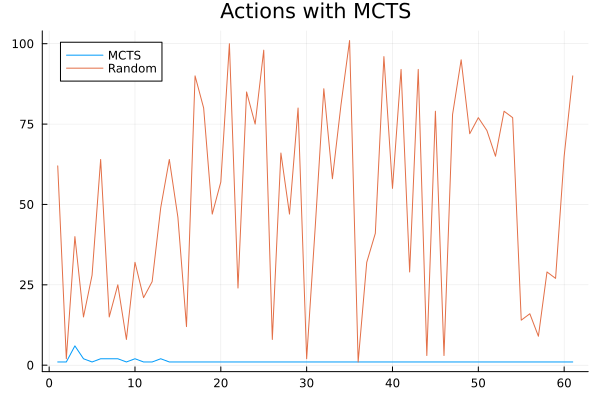

In [249]:
plot(index, action_list_mcts, title="Actions with MCTS", label="MCTS")
plot!(index, action_list, label="Random")

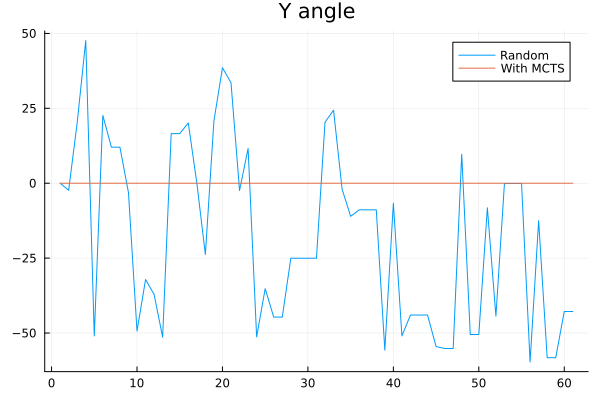

In [250]:
plot(index, [y_angle_list, y_angle_list_mcts], label=["Random" "With MCTS"], title="Y angle")


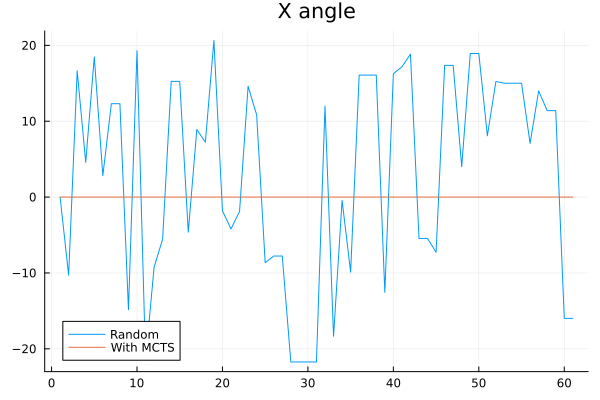

In [251]:
plot(index, [x_angle_list, x_angle_list_mcts], label=["Random" "With MCTS"], title="X angle")

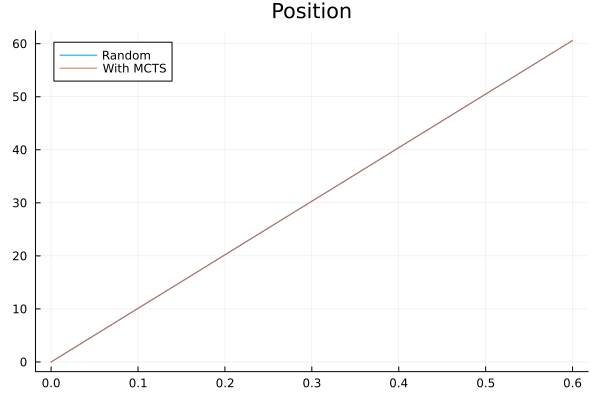

In [252]:
plot([x_list, x_list_mcts], [y_list, y_list_mcts], label=["Random" "With MCTS"], title="Position")
